# Learning to Fly a Quadcopter Drone using Neural Networks

<center>Vignesh M. Pagadala</center>
<center>Computer Science Department</center>
<center>Colorado State University</center>
<center>Email: Vignesh.Pagadala@colostate.edu</center>
<br>
<center> December 2017 </center>

## Abstract
Drone technology has seen massive improvements over the last decade, involving enhancements in battery life, collision avoidance mechanisms and data processing [1], opening up enormous possibilities. Amazon has made it's intentions clear to fabricate a full-scale drone delivery mechanism, and is making significant progress towards the materialization of this goal.

In June of 2013, Raffaello D'Andrea of Amazon Robotics presented <a href = "https://www.youtube.com/watch?v=w2itwFJCgFQ">this</a> TED talk [2]. The entire talk was a rather flashy display of different types of drones and their aptitude. If this talk was meant to woo public opinion in their favour, it worked. At least on me it did. Needless to say, I was fascinated by the possibility quadcopters had to offer. 

Therefore, in this project, I intend to examine the prospect of using neural networks to enable a drone to learn how to fly.  A quadcopter has four rotors. It's flight is controlled entirely (increase and decrease in altitude, forward and sideways movement) by varying the speeds of each of these four rotors, and thereby altering the thrust generated by the same, causing movement. In my design, I configured a neural network to generate these thrust values as output, after taking in the location coordinates of the drone, and intended destination as input. The Unity engine shall serve as my platform for simulating the drone and its environment. Post-training over several iterations, the drone could make it to the target area, albeit rather clumsily.     

## Methodology
The drone is represented in the Unity environment as a 1 X 0.2 X 1 cuboid, with the assumption that each rotor is present at each of the four bottom corners of this figure. It's subjected to a downward acceleration-due-to-gravity 'g', but with a catch. In this environment, we shall assume that g = 8 m/s^2 as opposed to the actual value of 9.81 m/s^2 in the real world. This is done for the sake of simplicity of calculations (easier to divide the value amongst the four rotors). Also, the object's mass is designated to be 1 Kg. 

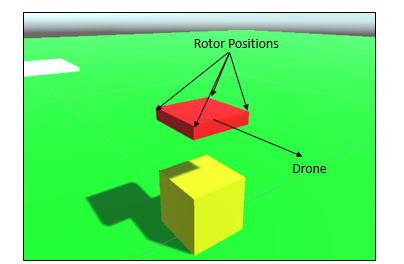


Our objective is to get the drone to 'land' on top of the white platform, which shall serve as the target destination. In order to generate the training data to train the neural network with, several games are played by a human user, in which attempts are made to try and land the drone in the target area. The neural network shall be designed as follows. It shall comprise of 6 input and 4 output neurons with an arbitrary number of hidden-layer neurons (shall be discussed in later sections). The 6 inputs are (1) the x, y and z coordinates of the current drone location, and (2) the x, y and z coordinates of the target platform. Each of the 4 output neurons shall represent the value of the force to be exerted by each of the four rotors. The coordinates of the target are included in the input so as to add in some features dependent on the target-platform's location. This ensures that the drone can get to the target no matter its location.

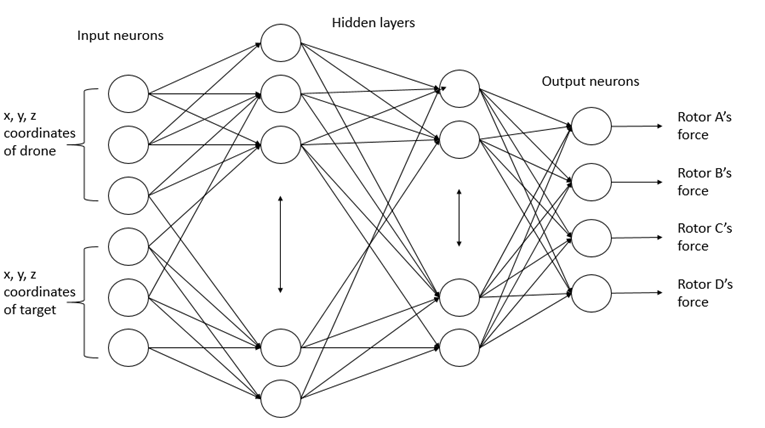

The first step which was required to be done was the collection of training data samples by playing several games. In order to achieve this, it was necessary to write a Unity C# script (included in the MoveCube.cs file) which provides fairly reasonable control over the drone for the user. Quite simple. Arrow keys to move forward, backward and sideways, and numpad 8 and 2 to increase and decrease altitude. Each action, however, had to be translated into the forces to be exerted at each 'rotor' to enforce the move. 

For example, when the up arrow key is pressed, the drone is supposed to move forwards. But for this, a torque has to be applied by increasing the force on the rear rotors and decreasing on the front ones. When the altitude has to be increased, the force on each rotor is uniformly increased. And to hover, each rotor maintains a force such that it properly counteracts the downward 'g'. In addition to this, code had to be written to provide proper stabilization for the drone. Otherwise, piloting the drone to the target became a rather difficult task (even for a human user). 

To collect training data, the following procedure was carried out. In MoveCube.cs, Update() is called once per frame. At each call of Update(), the coordinates of the drone position, and the target position (which is constant) is computed. Also, the force being exerted by each rotor at that point is also computed and everything is loaded onto a .csv file ('Train.csv'). This .csv file has 10 columns in the following order: x, y and z of drone location, x, y and z of target, force by rotors A, B, C and D. Let's take a look at the first 10 records.    

In [18]:
import pandas as pd
df=pd.read_csv('Train.csv', sep=',',header=None)
# Display first 10 records.
df.iloc[0:10, :]

,0,1,2,3,4,5,6,7,8,9
0,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
1,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
2,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
3,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
4,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
5,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
6,0.0,2.0000,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0
7,0.0,2.0000,0.0,0,0.125,18.99,6.0,6.0,6.0,6.0
8,0.0,2.0128,0.0,0,0.125,18.99,6.0,6.0,6.0,6.0
9,0.0,2.0384,0.0,0,0.125,18.99,2.0,2.0,2.0,2.0


We train the neural network using this data over several iterations. To do this I made use of the NeuralNetwork class implementation provided by Dr. Anderson in the CS440 class notes. After training is completed, we can use the trained network to get values for each position of the drone and target. But however, there was a problem. The neural network implementation which I planned to use was in Python, and Unity's MoveCube script is in C#. Therefore it became necessary to train the network seperately, and store this trained network in the file-system (so as to make is possible for the C# script to access this. This was done using the pickle package, as shall be demonstrated below. But first, let's obtain the training data as input and target values.

Note: The packages 'neuralnetworks', 'scaledconjugategradient' and 'mlutils' being made use of here were provided by Dr. Charles Anderson as a part of the CS440 class notes [3].  

In [20]:
import neuralnetworks as nn
import numpy as np
import matplotlib.pyplot as plt
import scaledconjugategradient as scg
import mlutils as ml
import pickle

In [17]:
# Load data from CSV file.
df=pd.read_csv('Train.csv', sep=',',header=None)

# Get target data - first 6 columns.
Td = df.iloc[:, 6:]
Td = Td.as_matrix()
Tdrone = Td.astype(float)

# Get input data - last 4 columns.
Xd = df.iloc[:, :6]
Xd = Xd.as_matrix()
Xdrone = Xd.astype(float)

Input data: x, y and z coordinates of drone and target.

In [21]:
Xdrone[0:10, :]

array([[  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.    ,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.0128,   0.    ,   0.    ,   0.125 ,  18.99  ],
       [  0.    ,   2.0384,   0.    ,   0.    ,   0.125 ,  18.99  ]])

Target data: Force exerted by each of the 4 rotors.

In [22]:
Tdrone[0:10, :]

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 6.,  6.,  6.,  6.],
       [ 6.,  6.,  6.,  6.],
       [ 2.,  2.,  2.,  2.]])

Let's commence training. Here we use a neural network with one hidden layer with 5 neurons, for 100 iterations. This is done here just as an example to illustrate how the trained network class is stored in the file system. Otherwise, more iterations will be required.

In [25]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[5],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 10, verbose = True)

SCG: Iteration 1 ObjectiveF=0.40798 Scale=1.000e-06 Time=0.00075 s/iter
SCG: Iteration 2 ObjectiveF=0.40798 Scale=5.000e-07 Time=0.00070 s/iter
SCG: Iteration 3 ObjectiveF=0.40798 Scale=2.000e-06 Time=0.00030 s/iter
SCG: Iteration 4 ObjectiveF=0.40798 Scale=8.000e-06 Time=0.00030 s/iter
SCG: Iteration 5 ObjectiveF=0.40798 Scale=3.200e-05 Time=0.00030 s/iter
SCG: Iteration 6 ObjectiveF=0.40798 Scale=1.280e-04 Time=0.00025 s/iter
SCG: Iteration 7 ObjectiveF=0.40798 Scale=5.120e-04 Time=0.00035 s/iter
SCG: Iteration 8 ObjectiveF=0.40798 Scale=2.048e-03 Time=0.00035 s/iter
SCG: Iteration 9 ObjectiveF=0.40798 Scale=8.192e-03 Time=0.00035 s/iter
SCG: Iteration 10 ObjectiveF=0.39849 Scale=3.277e-02 Time=0.00035 s/iter


NeuralNetwork(6, [5], 4)
   Network was trained for 11 iterations. Final error is 0.6312625848374165.

Now, we use pickle to store this trained neural network class to the file system.

In [26]:
pickle.dump(nnet, open("trainedNet", "wb"))

Now that this class instance is stored, we can access it from the file system and use the trained network to make predictions. 

In [28]:
trainedNet = pickle.load(open("trainedNet", "rb"))
sampleInput = [[0, 3.603078, 0.004936485, 0, 0.125, 18.99]]
trainedNet.use(sampleInput)

array([[ 2.2360522 ,  2.2360522 ,  2.23416161,  2.23416161]])

By storing the trained class instance in the file-system, we ensure that it can be accessed by the C# script from within Unity. After getting access to this, it becomes necessary to load this into C# and call the NeuralNetwork.use() function, to get the predicted rotor speeds. This part was a bit tricky. I had to run the Python interpreter from C# through the command line, and pass the Python code as a string to the interpreter using the -c option. After obtaining the rotor speeds as an output of use(), I passed them to the standard output from within Python and grabbed these values from the standard output in the C# script. All this is done for each call to MoveCube.update(), i.e. for each frame. This bit of code is displayed below, for the reader's perusal.

**The following segment of code is for observational purposes only, and not meant to be run.**

Therefore, for each frame, the drone gets the rotor force-values as predicted by the trained neural network and enforces it. Additionally, it has to be mentioned that, if the drone flips, that is, if it undergoes a rotation greater than 150 degrees, the program exits. 

## Results

Several neural network configurations and different number of iterations were examined, and the behaviour of the drone for each training parameter combination was observed. Let's start by training for 100 iterations with 5 hidden layer neurons.  

In [48]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[5],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 100, verbose = True)

SCG: Iteration 10 ObjectiveF=0.33812 Scale=6.250e-08 Time=0.00080 s/iter
SCG: Iteration 20 ObjectiveF=0.28623 Scale=6.104e-11 Time=0.00000 s/iter
SCG: Iteration 30 ObjectiveF=0.26642 Scale=9.537e-13 Time=0.00070 s/iter
SCG: Iteration 40 ObjectiveF=0.26332 Scale=3.052e-11 Time=0.00000 s/iter
SCG: Iteration 50 ObjectiveF=0.26332 Scale=3.200e-05 Time=0.00000 s/iter
SCG: Iteration 60 ObjectiveF=0.26012 Scale=1.024e-03 Time=0.00000 s/iter
SCG: Iteration 70 ObjectiveF=0.25800 Scale=1.000e-06 Time=0.00156 s/iter
SCG: Iteration 80 ObjectiveF=0.25449 Scale=1.953e-09 Time=0.00000 s/iter
SCG: Iteration 90 ObjectiveF=0.25381 Scale=3.815e-12 Time=0.00070 s/iter
SCG: Iteration 100 ObjectiveF=0.25334 Scale=3.725e-15 Time=0.00000 s/iter


NeuralNetwork(6, [5], 4)
   Network was trained for 101 iterations. Final error is 0.5033331775603603.

In [49]:
err = nnet.getErrorTrace()
err

array([ 0.70710678,  0.64822267,  0.63414373,  0.634143  ,  0.62873959,
        0.61109412,  0.60601506,  0.60502764,  0.59376422,  0.58574352,
        0.5814806 ,  0.57345586,  0.56684825,  0.56354554,  0.55903737,
        0.54847447,  0.54547559,  0.54200513,  0.53743358,  0.5361026 ,
        0.53500502,  0.53029599,  0.5282617 ,  0.52588037,  0.52420247,
        0.52230557,  0.5220116 ,  0.52009855,  0.51891714,  0.51819905,
        0.51616197,  0.51550429,  0.5148177 ,  0.51387597,  0.5131429 ,
        0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,
        0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,
        0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,
        0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,  0.5131429 ,
        0.51182945,  0.51149964,  0.51127925,  0.5103233 ,  0.5100921 ,
        0.51002286,  0.50976967,  0.5093435 ,  0.50925497,  0.50911129,
        0.50885453,  0.50880074,  0.50872934,  0.50818991,  0.50

Let's plot the error trace to see if further iterations are required.

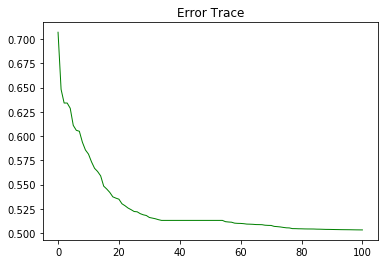

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(err, linewidth = 1, color = 'g')
ax.set(title = 'Error Trace')
plt.show()

More iterations do not seem to be required here. But let's just run the drone for this network to observe the results. To run the executable for this network, run the cell below. In case its too slow, the .gif below displays the same run of the simulator for this network configuration, sped up for the reader's convenience.

In [2]:
var = !Drone_Sim_5_100

** <center>Results after training for 100 iterations with 5 hidden-layer neurons.</center>**

![alt text](Drone_Sim_5_100.gif "Sim")

As expected, we can observe that, after the drone gains altitude, it ends up moving in a direction completely opposite to the target platform. Let's a different structure now.

In [51]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[20, 20],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 10, verbose = True)

SCG: Iteration 1 ObjectiveF=0.39892 Scale=1.000e-06 Time=0.00443 s/iter
SCG: Iteration 2 ObjectiveF=0.39062 Scale=5.000e-07 Time=0.00354 s/iter
SCG: Iteration 3 ObjectiveF=0.38718 Scale=2.500e-07 Time=0.00436 s/iter
SCG: Iteration 4 ObjectiveF=0.38151 Scale=1.250e-07 Time=0.00451 s/iter
SCG: Iteration 5 ObjectiveF=0.36974 Scale=6.250e-08 Time=0.00440 s/iter
SCG: Iteration 6 ObjectiveF=0.36607 Scale=3.125e-08 Time=0.00453 s/iter
SCG: Iteration 7 ObjectiveF=0.35131 Scale=1.562e-08 Time=0.00497 s/iter
SCG: Iteration 8 ObjectiveF=0.34563 Scale=7.812e-09 Time=0.00440 s/iter
SCG: Iteration 9 ObjectiveF=0.33216 Scale=3.906e-09 Time=0.00379 s/iter
SCG: Iteration 10 ObjectiveF=0.32807 Scale=1.953e-09 Time=0.00504 s/iter


NeuralNetwork(6, [20, 20], 4)
   Network was trained for 11 iterations. Final error is 0.5727721404654479.

In [52]:
err = nnet.getErrorTrace()
err

array([ 0.70710678,  0.63159742,  0.62499512,  0.6222401 ,  0.61766475,
        0.60806212,  0.60503946,  0.59271008,  0.58790235,  0.5763359 ,
        0.57277214])

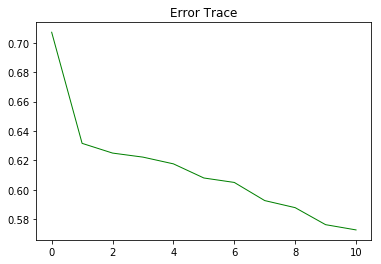

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(err, linewidth = 1, color = 'g')
ax.set(title = 'Error Trace')
plt.show()

More iterations are obviously necessary here since the error still seems to be decreasing. But let's execute the run anyway, for observational purposes.

In [3]:
var = !Drone_Sim_20_20_10

** <center>Results after training for 10 iterations with hidden-layer structure [20, 20].</center>**

![alt text](Drone_Sim_20_20_10.gif "Sim")

Once again, the drone fails to get anywhere close to the target platform. This is expected, since the error is still pretty high. Let's try more iterations.

In [56]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[20, 20],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 100, verbose = True)

SCG: Iteration 10 ObjectiveF=0.31727 Scale=3.906e-09 Time=0.00420 s/iter
SCG: Iteration 20 ObjectiveF=0.28524 Scale=3.815e-12 Time=0.00430 s/iter
SCG: Iteration 30 ObjectiveF=0.27203 Scale=3.725e-15 Time=0.00440 s/iter
SCG: Iteration 40 ObjectiveF=0.25992 Scale=1.000e-15 Time=0.00364 s/iter
SCG: Iteration 50 ObjectiveF=0.25455 Scale=1.000e-15 Time=0.00424 s/iter
SCG: Iteration 60 ObjectiveF=0.25195 Scale=1.000e-15 Time=0.00430 s/iter
SCG: Iteration 70 ObjectiveF=0.24766 Scale=1.000e-15 Time=0.00450 s/iter
SCG: Iteration 80 ObjectiveF=0.24496 Scale=1.000e-15 Time=0.00274 s/iter
SCG: Iteration 90 ObjectiveF=0.24201 Scale=1.000e-15 Time=0.00491 s/iter
SCG: Iteration 100 ObjectiveF=0.24015 Scale=1.000e-15 Time=0.00425 s/iter


NeuralNetwork(6, [20, 20], 4)
   Network was trained for 101 iterations. Final error is 0.49005528804669873.

In [57]:
err = nnet.getErrorTrace()
err

array([ 0.70710678,  0.64097596,  0.63414235,  0.62318392,  0.61605095,
        0.6067891 ,  0.60289994,  0.58955174,  0.58425363,  0.5700983 ,
        0.56327156,  0.55632113,  0.55478652,  0.55283451,  0.55042569,
        0.54923939,  0.5451876 ,  0.54399717,  0.54115988,  0.53849588,
        0.53408125,  0.53094379,  0.52982913,  0.52918402,  0.52741005,
        0.52698742,  0.52615761,  0.52544963,  0.52381658,  0.5228107 ,
        0.52156441,  0.52026006,  0.51879828,  0.517389  ,  0.51651774,
        0.51580748,  0.51560104,  0.51456311,  0.51365589,  0.5103552 ,
        0.50982824,  0.50848162,  0.50759275,  0.50625348,  0.5059033 ,
        0.50573987,  0.50556708,  0.50533233,  0.50496637,  0.50476101,
        0.50453319,  0.50443032,  0.50400472,  0.50383518,  0.50370317,
        0.50341038,  0.50320354,  0.50292399,  0.50256756,  0.50238471,
        0.50194658,  0.50091161,  0.50082187,  0.50028265,  0.49972919,
        0.49936448,  0.4991192 ,  0.49859479,  0.49832285,  0.49

Let's plot the error trace to see if further iterations are required.

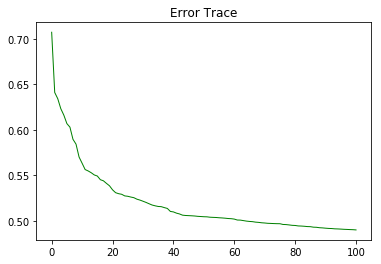

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(err, linewidth = 1, color = 'g')
ax.set(title = 'Error Trace')
plt.show()

In [4]:
var = !Drone_Sim_20_20_100

** <center>Results after training for 100 iterations with hidden-layer structure [20, 20].</center>**

![alt text](Drone_Sim_20_20_100.gif "Sim")

Now, we can notice that the drone attempts to move towards the general direction of the target platform, which is certainly an improvement from the previous version. This can be attributed to the increased number of iterations and reduced error rate from the training. Let's try 400 iterations.

In [60]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[20, 20],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 400, verbose = True)

SCG: Iteration 40 ObjectiveF=0.27428 Scale=1.000e-15 Time=0.00430 s/iter
SCG: Iteration 80 ObjectiveF=0.25551 Scale=1.000e-15 Time=0.00430 s/iter
SCG: Iteration 120 ObjectiveF=0.24812 Scale=1.000e-15 Time=0.00440 s/iter
SCG: Iteration 160 ObjectiveF=0.24189 Scale=1.000e-15 Time=0.00433 s/iter
SCG: Iteration 200 ObjectiveF=0.23439 Scale=1.000e-15 Time=0.00420 s/iter
SCG: Iteration 240 ObjectiveF=0.22592 Scale=1.000e-15 Time=0.00450 s/iter
SCG: Iteration 280 ObjectiveF=0.21489 Scale=1.000e-15 Time=0.00410 s/iter
SCG: Iteration 320 ObjectiveF=0.20578 Scale=1.000e-15 Time=0.00440 s/iter
SCG: Iteration 360 ObjectiveF=0.19584 Scale=1.000e-15 Time=0.00460 s/iter
SCG: Iteration 400 ObjectiveF=0.18588 Scale=1.000e-15 Time=0.00423 s/iter


NeuralNetwork(6, [20, 20], 4)
   Network was trained for 401 iterations. Final error is 0.43113409684260046.

In [61]:
err = nnet.getErrorTrace()
err

array([ 0.70710678,  0.63818046,  0.63101276,  0.62428892,  0.61536928,
        0.60222162,  0.59500809,  0.58581067,  0.56951824,  0.56427111,
        0.56033304,  0.55916998,  0.55459558,  0.55190442,  0.55028444,
        0.54810139,  0.54646884,  0.54536177,  0.5451632 ,  0.54421253,
        0.54268686,  0.54103061,  0.5404284 ,  0.53990368,  0.53948343,
        0.53935142,  0.53860183,  0.53830493,  0.53818497,  0.53664219,
        0.53501322,  0.53409792,  0.53048434,  0.52975007,  0.52781268,
        0.52715366,  0.52640123,  0.52595374,  0.52579814,  0.52514907,
        0.5237213 ,  0.5234272 ,  0.5232068 ,  0.52277239,  0.52238006,
        0.52112062,  0.52046732,  0.51976397,  0.51920216,  0.51835815,
        0.5180867 ,  0.51742971,  0.51660689,  0.51614959,  0.51604922,
        0.51554468,  0.51531362,  0.51496329,  0.51476268,  0.51404505,
        0.51382718,  0.51363805,  0.51318633,  0.51235248,  0.51222723,
        0.51182572,  0.51162159,  0.51134218,  0.5110108 ,  0.51

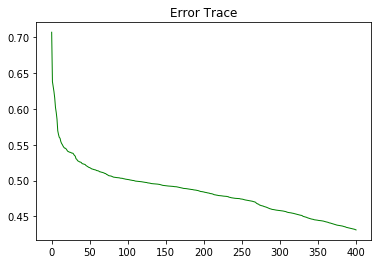

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(err, linewidth = 1, color = 'g')
ax.set(title = 'Error Trace')
plt.show()

Still appears to be decreasing. Let's add more iterations, but let's execute this first.

In [5]:
var = !Drone_Sim_20_20_400

** <center>Results after training for 400 iterations with hidden-layer structure [20, 20].</center>**

![alt text](Drone_Sim_20_20_400.gif "Sim")

Not much improvement from the previous version. Let's try 5000 iterations with this structure.

In [63]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[20, 20],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 5000, verbose = True)

SCG: Iteration 500 ObjectiveF=0.16681 Scale=1.000e-15 Time=0.00533 s/iter
SCG: Iteration 1000 ObjectiveF=0.12905 Scale=1.000e-15 Time=0.00313 s/iter
SCG: Iteration 1500 ObjectiveF=0.11312 Scale=1.000e-15 Time=0.00420 s/iter
SCG: Iteration 2000 ObjectiveF=0.10241 Scale=1.000e-15 Time=0.00420 s/iter
SCG: Iteration 2500 ObjectiveF=0.09583 Scale=1.000e-15 Time=0.00433 s/iter
SCG: Iteration 3000 ObjectiveF=0.08993 Scale=1.000e-15 Time=0.00420 s/iter
SCG: Iteration 3500 ObjectiveF=0.08805 Scale=1.000e-15 Time=0.00440 s/iter
SCG: Iteration 4000 ObjectiveF=0.08625 Scale=1.000e-15 Time=0.00440 s/iter
SCG: Iteration 4500 ObjectiveF=0.08499 Scale=1.000e-15 Time=0.00424 s/iter
SCG: Iteration 5000 ObjectiveF=0.08401 Scale=1.000e-15 Time=0.00422 s/iter


NeuralNetwork(6, [20, 20], 4)
   Network was trained for 5001 iterations. Final error is 0.2898461727224598.

In [66]:
err = nnet.getErrorTrace()

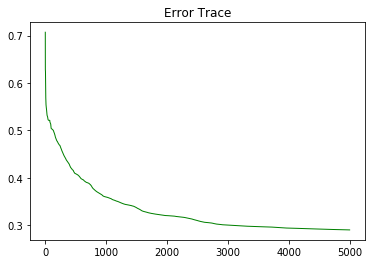

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(err, linewidth = 1, color = 'g')
ax.set(title = 'Error Trace')
plt.show()

In [6]:
var = !Drone_Sim_20_20_5K

**<center>Results after training for 5000 iterations with hidden-layer structure [20, 20].</center>**

![alt text](Drone_Sim_20_20_5K.gif "Sim")

It may be noted that, in the above scenario, the drone successfully makes its way towards the target. This time, however, once close to the target, it attempts to slow down by tilting backwards, in order to make a proper landing on the platform. However, a little excessive torque is applied and it's ultimately unsuccessful in executing the landing. But it is interesting to observe the way it tries to slow down, once near the landing zone. Let's try some other network configuration. 

In [71]:
nnet = nn.NeuralNetwork(Xdrone.shape[1],[15, 15],Tdrone.shape[1])
nnet.train(Xdrone, Tdrone, nIterations = 1000, verbose = True)

SCG: Iteration 100 ObjectiveF=0.25208 Scale=1.000e-15 Time=0.00360 s/iter
SCG: Iteration 200 ObjectiveF=0.24104 Scale=1.000e-15 Time=0.00320 s/iter
SCG: Iteration 300 ObjectiveF=0.22194 Scale=1.000e-15 Time=0.00315 s/iter
SCG: Iteration 400 ObjectiveF=0.20136 Scale=1.000e-15 Time=0.00315 s/iter
SCG: Iteration 500 ObjectiveF=0.17944 Scale=1.000e-15 Time=0.00315 s/iter
SCG: Iteration 600 ObjectiveF=0.16275 Scale=1.000e-15 Time=0.00328 s/iter
SCG: Iteration 700 ObjectiveF=0.15083 Scale=1.000e-15 Time=0.00320 s/iter
SCG: Iteration 800 ObjectiveF=0.14385 Scale=1.000e-15 Time=0.00321 s/iter
SCG: Iteration 900 ObjectiveF=0.14205 Scale=1.000e-15 Time=0.00310 s/iter
SCG: Iteration 1000 ObjectiveF=0.14011 Scale=1.000e-15 Time=0.00318 s/iter


NeuralNetwork(6, [15, 15], 4)
   Network was trained for 1001 iterations. Final error is 0.37431818965713576.

In [72]:
err = nnet.getErrorTrace()

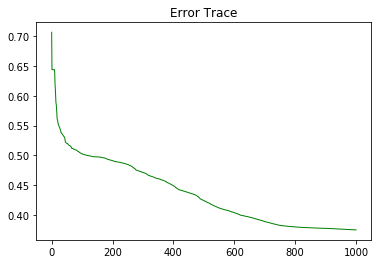

In [73]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(err, linewidth = 1, color = 'g')
ax.set(title = 'Error Trace')
plt.show()

In [7]:
var = !Drone_Sim_15_15_1K

**<center>Results after training for 1000 iterations with hidden-layer structure [15, 15].</center>**

![alt text](Drone_Sim_15_15_1K.gif "Sim")

With this configuration, and over 1000 iterations, the drone manages to make contact with the target area. 

## Inference and Contemplation

In the execution of this project, I explored the possibility of using neural networks to generate the rotor thrusts for flying a quadcopter. Different hidden-layer structures were tried with different iterations, and the behaviour of the drone with each type of trained network was observed. I might add, with a little dissatisfaction, that I did not, in fact, obtain the results I had anticipated. The drone was unable to execute a perfect, elegant landing, but however, was indeed capable of getting to the target area. I expected the drone to be able to execute a better landing, since that's how I had landed it when I played multiple games to generate training data. But I strongly attribute this to insufficient training data. A possible improvement could be achieved by possibly generating more training data, by playing even more games, and training over more iterations.

But it has to be taken into account, that there was indeed an improvement with the use of more iterations. For instance, after 100 iterations with the [20, 20] structure, the drone started moving in the direction of the target, instead of backwards. After 5000 iterations, the drone was indeed making attempts to slow down over the landing zone (by applying a reverse torque as observed). 

In any case, working on this project was indeed a constructive exercise in understanding neural networks and how to apply them to solve real-world scenarios. It also helped me to appreciate the immense potential that deep learning has to offer, in the context of solving real-world problems. 

## References
[1] <a href = "https://www.uav.org/7-key-improvements-being-made-to-drone-technology/ ">'7 Key Improvements being made to Drone Technology'</a> - UAV.org<br>
[2] Raffaello D'Andrea - <a href = "https://www.ted.com/talks/raffaello_d_andrea_the_astounding_athletic_power_of_quadcopters">'Meet the Dazzling Flying Machines of the Future'</a> - TED2016 <br>
[3] Dr. Charles Anderson - CS440 class notes. 